In [1]:
import geoutils.utils.file_utils as fut
import climnet.network.network_functions as nwf
import climnet.community_detection.membership_likelihood as ml
import graph_tool.all as gt
import climnet.network.boundary_correction as bc
import climnet.datasets.evs_dataset as cds
import xarray as xr
import geoutils.utils.time_utils as tu
import geoutils.utils.general_utils as gut
from importlib import reload
import numpy as np
import geoutils.tsa.time_series_analysis as tsa
import climnet.network.clim_networkx as cn
import geoutils.plotting.plots as cplt
import climnet.community_detection.graph_tool.gt_functions as gtf
import climnet.community_detection.graph_tool.es_graph_tool as egt


### Load Dataset and Network
For the analysis two different objects are required: 
- the dataset containing the data
- the network containing the information about the interconnections of locations

Both clases  are implemented in the climnet package. The node numbers correspond to the points dimension of the dataset. 

It is therefore required to pass the dataset class to the network to ensure that both network and dataset are consistent.

In [2]:
# Load the dataset
name = 'mswep'

grid_type = "fekete"
grid_step = 1
q_sig = 0.95

output_folder = "bsiso"
output_dir = "/home/strnad/data/climnet/outputs/"
plot_dir = "/home/strnad/data/plots/climnet/tutorial/"
lat_range = [-15, 45]
lon_range = [55, 150]

q_ee = .9
name_prefix = f"{name}_{grid_type}_{grid_step}_{q_ee}"
start_month = "Jun"
end_month = "Sep"
if start_month != "Jan" or end_month != "Dec":
    name_prefix += f"_{start_month}_{end_month}"
lb = True

nx_path_file = output_dir + \
        f"{output_folder}/{name_prefix}_{q_sig}_lat_{lat_range}_lon_{lon_range}_lb_ES_nx.gml.gz"
dataset_file = output_dir + \
    f"/{output_folder}/{name_prefix}_1979_2021_lat_{lat_range}_lon_{lon_range}_lb_ds.nc"

ds = cds.EvsDataset(
    load_nc=dataset_file,
    rrevs=False
)

Loading Data...
Load Dataset: /home/strnad/data/climnet/outputs//bsiso/mswep_fekete_1_0.9_Jun_Sep_1979_2021_lat_[-15, 45]_lon_[55, 150]_lb_ds.nc
Variables in dataset: ['pr', 'evs']
Set variable name to evs!
No mask initialized!
Evs datat is stored in dataset.
Init spatial evs-mask for EVS data of shape: (14610, 4722)
... Finished Initialization EVS-spatial mask
Init the point-idx dictionaries


In [4]:
# and load the network
reload(cn)
cnx = cn.Clim_NetworkX(dataset=ds, nx_path_file=nx_path_file)

Load /home/strnad/data/climnet/outputs/bsiso/mswep_fekete_1_0.9_Jun_Sep_0.95_lat_[-15, 45]_lon_[55, 150]_lb_ES_nx.gml.gz...
... Loading /home/strnad/data/climnet/outputs/bsiso/mswep_fekete_1_0.9_Jun_Sep_0.95_lat_[-15, 45]_lon_[55, 150]_lb_ES_nx.gml.gz successful!
WARNING! Undirected graph object!
Casted to DiGraph object!
Load removal of isolated points...
Deleted 7 points from dataset...
Init the point-idx dictionaries
Set dataset source attributes!
No isolated nodes!
Create ds for all attributes present in node 0.
Network is unweighted!
Network Info: {'Num_nodes': 4258, 'Num_edges': 1316064, 'sparsity': 0.07258814452766059, 'Node_attrs': ['lon', 'lat', 'rempoints', 'degree', 'in_degree', 'out_degree', 'divergence', 'weight', 'formanCurvature', 'clustering', 'transitivity', 'betweenness'], 'Edge_attrs': ['weight', 'formanCurvature', 'length', 'betweenness']}


### Plot of the network link
To visually analyze the network it can be useful to plot the network links for single locations or a region.

This is done below for a user-defined region.

number of edges: 297


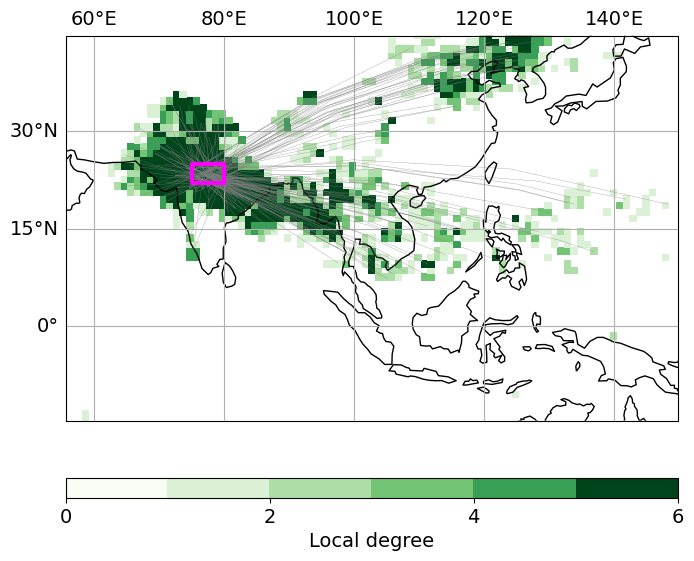

In [ ]:
# Plot the network links for a certain location

# %%
reload(cplt)
lat_range = [22, 25]
lon_range = [75, 80]
link_dict = cnx.get_edges_nodes_for_region(
    lon_range=lon_range, lat_range=lat_range, binary=False
)

# Plot nodes where edges go to
im = cplt.plot_map(
    link_dict['target_map'],
    label=f"Local degree",
    projection="PlateCarree",
    plt_grid=True,
    plot_type="colormesh",
    cmap="Greens",
    vmin=0,
    vmax=6,
    levels=6,
    bar=False,
    alpha=0.7,
    size=10,
    # tick_step=2,
    fillstyle="none",
)

im = cplt.plot_edges(
    cnx.ds,
    link_dict['el'][::10],
    ax=im["ax"],
    significant_mask=True,
    orientation="vertical",
    projection="EqualEarth",
    lw=0.2,
    alpha=0.6,
    color="grey",
    plot_grid=False,
)

cplt.plot_rectangle(
    ax=im["ax"],
    lon_range=lon_range,
    lat_range=lat_range,
    color="magenta",
    lw=3,
    zorder=11
)
savepath = f"{plot_dir}/network_plots/{name_prefix}_{lon_range}_links.png"
cplt.save_fig(savepath)

### Link length distribution
It might be also interesting to look at the spatial link length distribution of all detected network edges. 

The function to compute the link length distribution is already implemented in the climnet package.

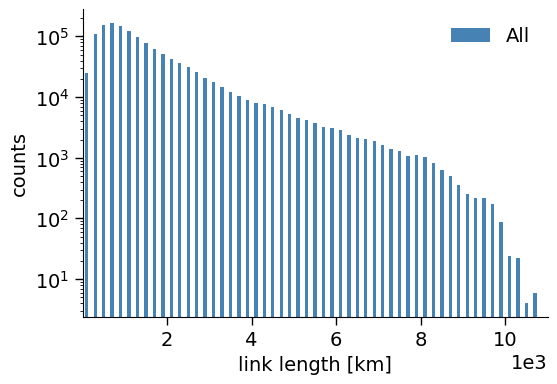

In [8]:
labels = ['All']
link_length_0 = cnx.get_link_length_distribution()
link_lengths = [
    link_length_0,
]
im = cplt.plot_hist(
    link_lengths,
    density=False,
    #    nbins=100,
    bw=200,  # km bin width
    xlim=(0.1, 1.1e4),
    log=False,
    ylog=True,
    bar=True,
    label_arr=labels,
    xlabel='link length [km]',
    ylabel='counts',
    loc='upper right',
    sci=3)


### Community detection
We apply a community detection algorithm on the adjacency matrix of the network graph.

We use the [Graph-tool](https://graph-tool.skewed.de/) algorithm to detect the communities.

We have further adopted the functions to make them easier to use and plot for visual analytics.

In [5]:
# %%
reload(egt)
reload(gtf)
# get graph tool graph
graph = gtf.construct_graph_from_network(cnx.cnx)


In [6]:
# Apply SBM
reload(egt)
B_max = 6
state = egt.apply_SBM(graph, B_max=B_max, multi_level=False)
theta = egt.post_process_SBM(state, graph)

Start computing SBM on graph...
Compute Blockmodel on single level...
Finished minimize 1 - level Blockmodel!
Elapsed time for SBM: 116.74
New number of groups: 6 < previous: 4259


/home/strnad/climnet/monsoon/climnet/community_detection/graph_tool/es_graph_tool.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  group_levels = np.array(group_levels.tolist() + [np.zeros(ng)])


In [35]:
# Quantify the uncertainty
reload(egt)
state, uncertainty = egt.quantify_uncertainty(state, mc_steps=50)


Sample from the posterior in 50 samples!
 Finished MCMC search! Improvement: -11.624653159407899


In [36]:
group_parts = np.array(list(uncertainty.get_partitions().values()))
group_parts.shape

reload(ml)
comm_dict =  ml.get_prob_maps_community(
    ds=cnx.ds,
    thetas=group_parts,
    sig_th=0.8,
    exclude_outlayers=False,
)

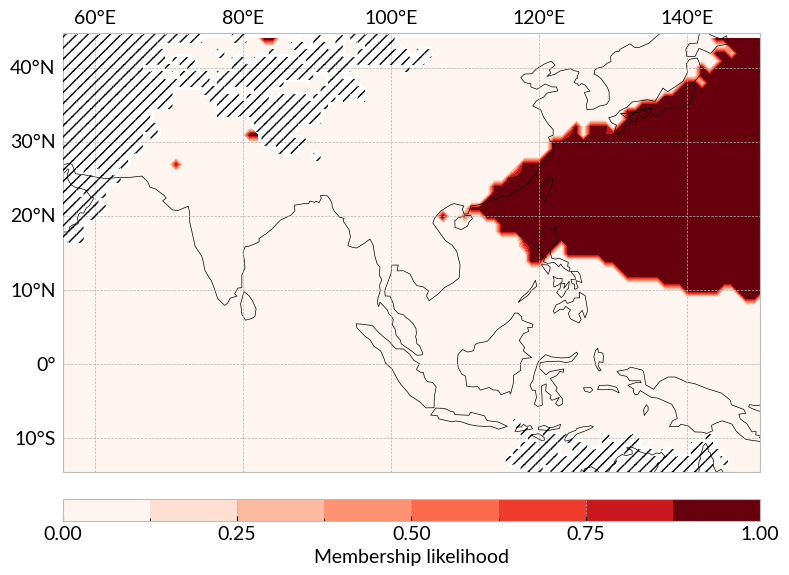

In [37]:
reload(cplt)
# this plots the sbm on a map
im = cplt.plot_map(
    comm_dict[3]['prob_map'],
    ds=cnx.ds,
    significance_mask=True,
    # plot_type="discrete",
    projection="PlateCarree",
    cmap='Reds',
    vmin=0, vmax=1,
    extend="neither",
    label="Membership likelihood",
    orientation="horizontal",
)


After the communities are calculated, we set them as node properties.

In [23]:
reload(nwf)
# set the node properties
nwf.set_node_attr_array(cnx.cnx,  comm_dict['hard_cluster'], "community_number")


Set Node Attribute {attr_name}...


{'lon': 129.342952776209,
 'lat': 41.8800762221772,
 'rempoints': 358,
 'degree': 421,
 'in_degree': 184,
 'out_degree': 237,
 'divergence': -53,
 'weight': 1.0,
 'formanCurvature': -342.98595505617976,
 'clustering': 0.25834783984807724,
 'transitivity': 0.4660723680290351,
 'betweenness': 0.0005860510495384093,
 'community_number': array([1, 1, 1, ..., 5, 1, 3])}

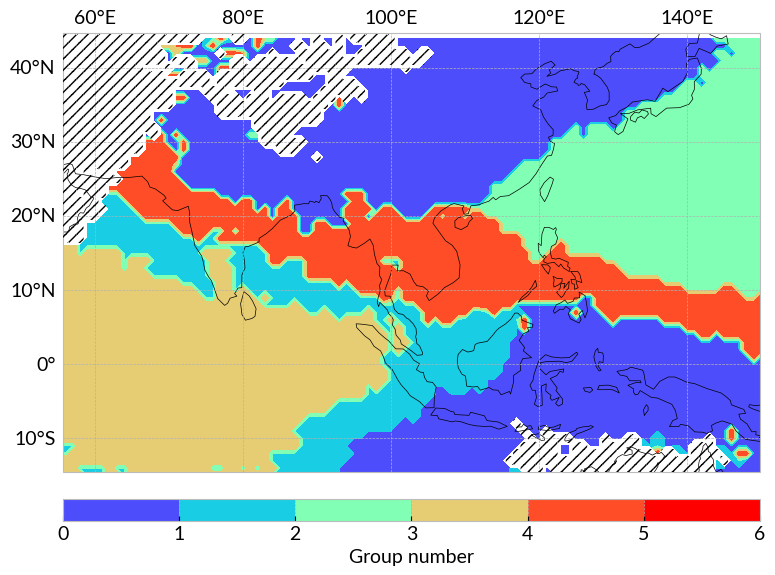

In [38]:
reload(cplt)
# this plots the nodes
hard_cluster = comm_dict['hard_cluster']
hc_map = cnx.ds.get_map(hard_cluster)
im = cplt.plot_map(
    hc_map,
    ds=cnx.ds,
    significance_mask=True,
    plot_type="discrete",
    projection="PlateCarree",
    cmap='rainbow',
    extend="neither",
    label="Group number",
    orientation="horizontal",
)

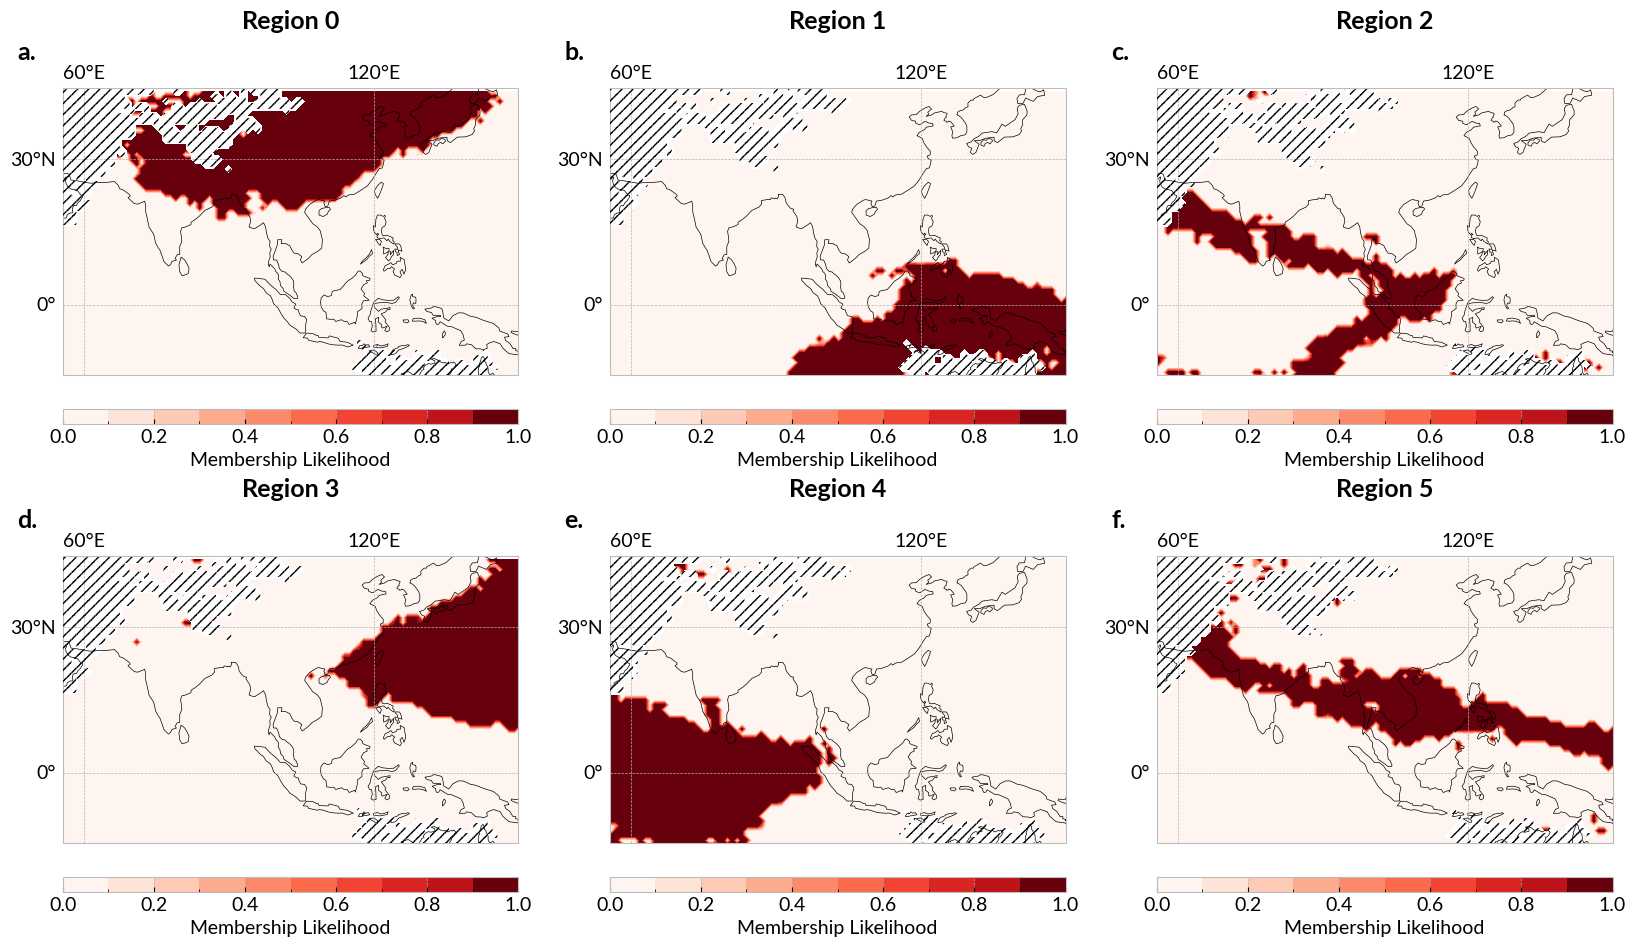

In [39]:
# Now plot all proability maps
num_comm = 6
im = cplt.create_multi_plot(nrows=2, ncols=int(num_comm/2),
                            figsize=(20, 10),
                            projection='PlateCarree',
                            hspace=0.55,
                            wspace=0.2,
                            )
for idx, region in enumerate(np.arange(0, num_comm)):
    gr_map = comm_dict[region]['prob_map']
    im_ml = cplt.plot_map(
        gr_map,
        ax=im['ax'][idx],
        ds=cnx.ds,
        significance_mask=True,
        plot_type="contourf",
        cmap="Reds",
        levels=10,
        vmin=0,
        vmax=1,
        title=f"Region {region}",
        extend="neither",
        label="Membership Likelihood",
        orientation="horizontal"
    )